<a href="https://colab.research.google.com/github/ujipet/diplomaterv/blob/master/Dipterv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
from google.colab import files
from numpy import array

Using TensorFlow backend.


In [2]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = False
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = False

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 88s 1us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [18]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
Learning rate:  0.001
50000/50000 [==============================] - 45s 892us/step - loss: 1.5513 - acc: 0.4847 - val_loss: 1.9637 - val_acc: 0.4261

Epoch 00001: val_acc improved from -inf to 0.42610, saving model to /content/saved_models/cifar10_ResNet20v1_model.001.h5
Epoch 2/200
Learning rate:  0.001
50000/50000 [==============================] - 40s 790us/step - loss: 1.1186 - acc: 0.6422 - val_loss: 1.3162 - val_acc: 0.5876

Epoch 00002: val_acc improved from 0.42610 to 0.58760, saving model to /content/saved_models/cifar10_ResNet20v1_model.002.h5
Epoch 3/200
Learning rate:  0.001
50000/50000 [==============================] - 40s 792us/step - loss: 0.9321 - acc: 0.7129 - val_loss: 1.2240 - val_acc: 0.6134

Epoch 00003: val_acc improved from 0.58760 to 0.61340, saving model to /content/saved_models/cifar10_ResNet20v1_model.003.h5
Epoch 4/200
Learning rate:  0.001
50000/50000 [=============

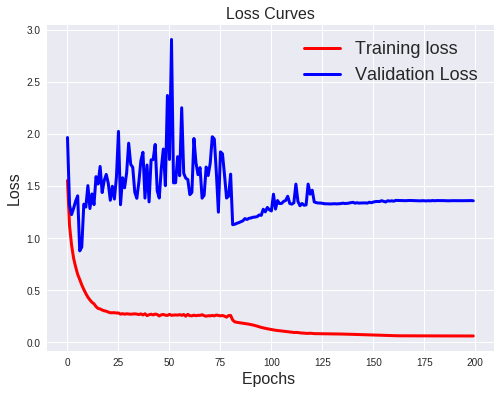

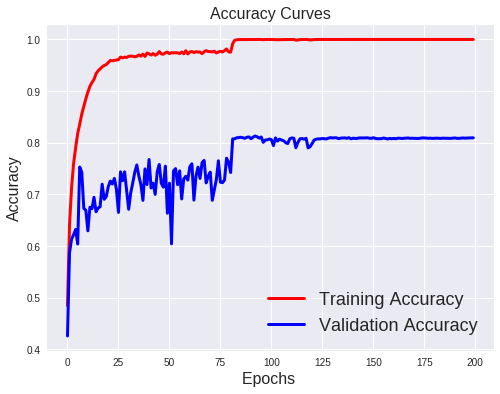

In [20]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
fig1 = plt.gcf()
plt.show()
fig1.savefig('alap_loss_curves.png')
files.download('alap_loss_curves.png')



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['acc'],'r',linewidth=3.0)
plt.plot(model.history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
fig2 = plt.gcf()
plt.show()
fig2.savefig('alap_accuracy_curves.png')
files.download('alap_accuracy_curves.png')

In [21]:
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
yy_test = np.argmax(np.round(y_test),axis=1)

from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(yy_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.76      0.86      0.81      1000
    Class 1       0.91      0.91      0.91      1000
    Class 2       0.75      0.72      0.73      1000
    Class 3       0.66      0.62      0.64      1000
    Class 4       0.77      0.77      0.77      1000
    Class 5       0.73      0.73      0.73      1000
    Class 6       0.85      0.86      0.86      1000
    Class 7       0.86      0.83      0.84      1000
    Class 8       0.89      0.90      0.90      1000
    Class 9       0.89      0.88      0.88      1000

avg / total       0.81      0.81      0.81     10000



# **ResNet20v1 500 kép**

In [0]:
index = np.argmax(np.round(y_train),axis=1)

In [0]:
def separate(n_number,index):
  nulla = 0
  egy = 0
  ketto = 0
  harom = 0
  negy = 0
  ot = 0
  hat = 0
  het = 0
  nyolc = 0
  kilenc = 0
  igaz = True
  i = 0
  x = n_number
  a = []
  b = []
  igaz = True
  while(igaz):
      #print('Index: ',index[i],' elem ',i,' Y_Train: ', y_train[i])
      #print('1: ',egy,'- 2: ',ketto,'- 3:',harom)
      if((nulla < x) & (index[i] == 0)):
          a.append(y_train[i])
          b.append(x_train[i])
          nulla = nulla + 1
      if((egy < x) & (index[i] == 1)):
          a.append(y_train[i])
          b.append(x_train[i])
          egy = egy + 1
      if((ketto < x) & (index[i] == 2)):
          a.append(y_train[i])
          b.append(x_train[i])
          ketto = ketto + 1
      if((harom < x) & (index[i] == 3)):
          a.append(y_train[i])
          b.append(x_train[i])
          harom = harom + 1
      if((negy < x) & (index[i] == 4)):
          a.append(y_train[i])
          b.append(x_train[i])
          negy = negy + 1
      if((ot < x) & (index[i] == 5)):
          a.append(y_train[i])
          b.append(x_train[i])
          ot = ot + 1
      if((hat < x) & (index[i] == 6)):
          a.append(y_train[i])
          b.append(x_train[i])
          hat = hat + 1
      if((het < x) & (index[i] == 7)):
          a.append(y_train[i])
          b.append(x_train[i])
          het = het + 1
      if((nyolc < x) & (index[i] == 8)):
          a.append(y_train[i])
          b.append(x_train[i])
          nyolc = nyolc + 1 
      if((kilenc < x) & (index[i] == 9)):
          a.append(y_train[i])
          b.append(x_train[i])
          kilenc = kilenc + 1
      if ((nulla == x) & (egy == x) & (ketto == x) & (harom == x) & (negy == x) & (ot == x) & (hat == x) & (het == x) & (nyolc == x) & (kilenc == x)):
          igaz = False
      i = i+1
  a_n = array(a)
  b_n = array(b)
  return a_n,b_n

In [0]:
a,b = separate(500,index)

In [16]:
b

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [26]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(b, a,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
_______________________________________________________________________________________

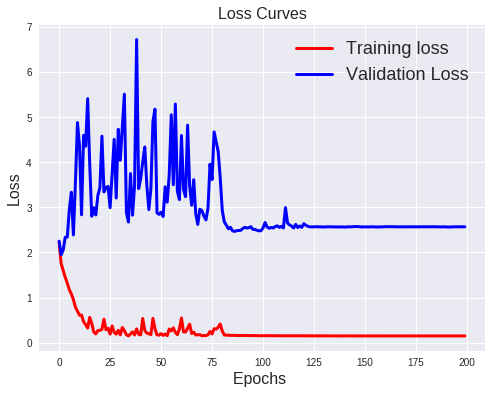

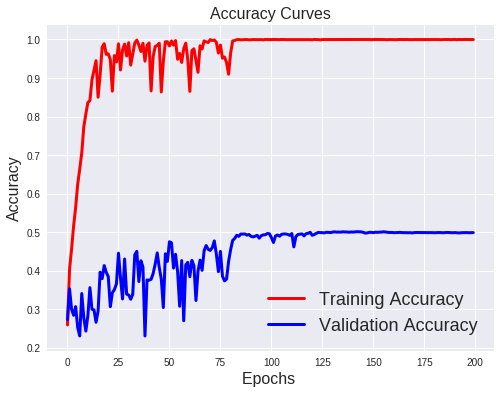

In [27]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
fig1 = plt.gcf()
plt.show()
fig1.savefig('500_loss_curves.png')
files.download('500_loss_curves.png')



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['acc'],'r',linewidth=3.0)
plt.plot(model.history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
fig2 = plt.gcf()
plt.show()
fig2.savefig('500_accuracy_curves.png')
files.download('500_accuracy_curves.png')

In [28]:
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
yy_test = np.argmax(np.round(y_test),axis=1)

from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(yy_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.35      0.60      0.44      1000
    Class 1       0.63      0.61      0.62      1000
    Class 2       0.42      0.38      0.40      1000
    Class 3       0.31      0.26      0.29      1000
    Class 4       0.42      0.38      0.40      1000
    Class 5       0.43      0.41      0.42      1000
    Class 6       0.58      0.53      0.55      1000
    Class 7       0.57      0.50      0.54      1000
    Class 8       0.63      0.66      0.64      1000
    Class 9       0.61      0.52      0.56      1000

avg / total       0.49      0.49      0.49     10000



# **ResNet20v1 50**

In [0]:
a,b = separate(50,index)

In [32]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(b, a,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_39[0][0]     
_______________________________________________________________________________________

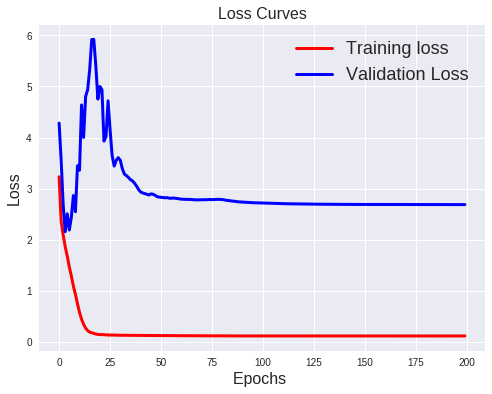

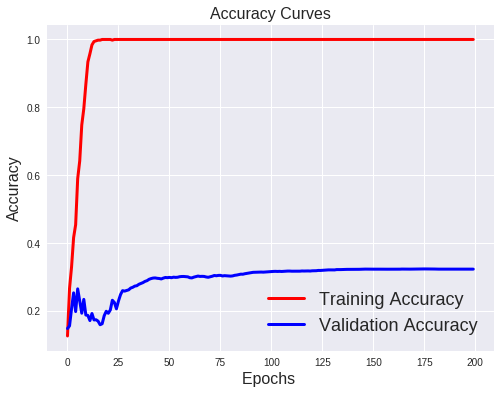

In [33]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
fig1 = plt.gcf()
plt.show()
fig1.savefig('50_loss_curves.png')
files.download('50_loss_curves.png')



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['acc'],'r',linewidth=3.0)
plt.plot(model.history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
fig2 = plt.gcf()
plt.show()
fig2.savefig('50_accuracy_curves.png')
files.download('50_accuracy_curves.png')

In [34]:
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
yy_test = np.argmax(np.round(y_test),axis=1)

from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(yy_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.14      0.47      0.21      1000
    Class 1       0.42      0.29      0.34      1000
    Class 2       0.25      0.21      0.23      1000
    Class 3       0.23      0.12      0.16      1000
    Class 4       0.33      0.30      0.31      1000
    Class 5       0.30      0.15      0.20      1000
    Class 6       0.38      0.30      0.33      1000
    Class 7       0.42      0.25      0.31      1000
    Class 8       0.42      0.43      0.43      1000
    Class 9       0.39      0.26      0.31      1000

avg / total       0.33      0.28      0.29     10000



# **ResNet20v1 5**

In [0]:
index = np.argmax(np.round(y_train),axis=1)

In [0]:
a,b = separate(5,index)

In [37]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(b, a,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 32, 32, 16)   64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 32, 32, 16)   0           batch_normalization_58[0][0]     
_______________________________________________________________________________________

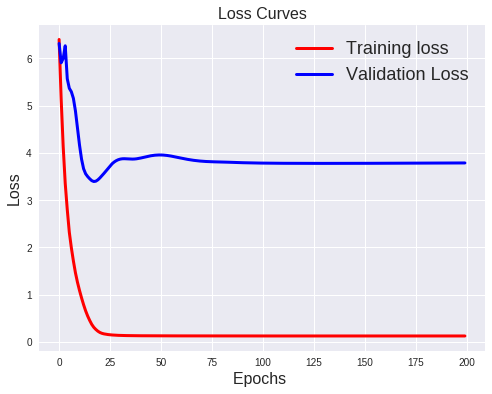

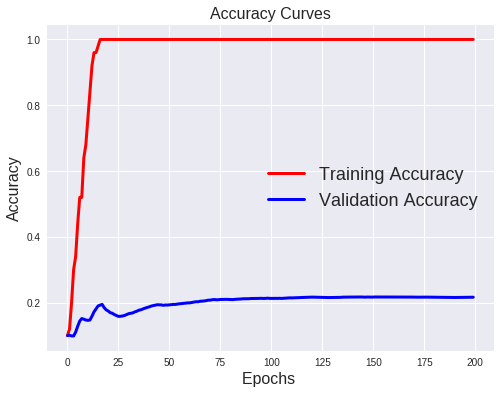

In [38]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
fig1 = plt.gcf()
plt.show()
fig1.savefig('5_loss_curves.png')
files.download('5_loss_curves.png')



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['acc'],'r',linewidth=3.0)
plt.plot(model.history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
fig2 = plt.gcf()
plt.show()
fig2.savefig('5_accuracy_curves.png')
files.download('5_accuracy_curves.png')

In [39]:
predicted_classes = model.predict(x_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
yy_test = np.argmax(np.round(y_test),axis=1)

from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(yy_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.07      0.23      0.11      1000
    Class 1       0.29      0.23      0.26      1000
    Class 2       0.08      0.05      0.06      1000
    Class 3       0.25      0.12      0.17      1000
    Class 4       0.17      0.16      0.17      1000
    Class 5       0.13      0.09      0.10      1000
    Class 6       0.27      0.32      0.29      1000
    Class 7       0.49      0.04      0.07      1000
    Class 8       0.32      0.40      0.35      1000
    Class 9       0.31      0.24      0.27      1000

avg / total       0.24      0.19      0.19     10000



# GrayScale #1 (AVG)

In [0]:
# Create a Grayscale version of the image
def convert_grayscale_avg(kep):
    # Get size
    width, height = 32,32
    # Create new Image and a Pixel Map
    new = kep.copy()
    
    for t in range(len(new)):
        for i in range(width):
            for j in range(height):

                # Get R, G, B values (This are int from 0 to 255)
                red =   new[t,i,j,0]
                green = new[t,i,j,1]
                blue =  new[t,i,j,2]

                # Transform to grayscale
                gray = (red + green + blue) / 3

                # Set Pixel in new image
                new[t,i, j, 0] = int(gray)
                new[t,i, j, 1] = int(gray)
                new[t,i, j, 2] = int(gray)
                

    # Return new image
    return new

In [0]:
grayscale_avg_train = x_train.copy()
grayscale_avg_train = grayscale_avg_train*255
grayscale_avg_train = convert_grayscale_avg(grayscale_avg_train)
grayscale_avg_test = x_test.copy()
grayscale_avg_test = grayscale_avg_test*255
grayscale_avg_test = convert_grayscale_avg(grayscale_avg_test)

In [0]:
grayscale_avg_train = grayscale_avg_train.astype('float32') / 255
grayscale_avg_test = grayscale_avg_test.astype('float32') / 255

In [19]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(grayscale_avg_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(grayscale_avg_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(grayscale_avg_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 32, 32, 16)   64          conv2d_64[0][0]                  
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 32, 32, 16)   0           batch_normalization_58[0][0]     
_______________________________________________________________________________________

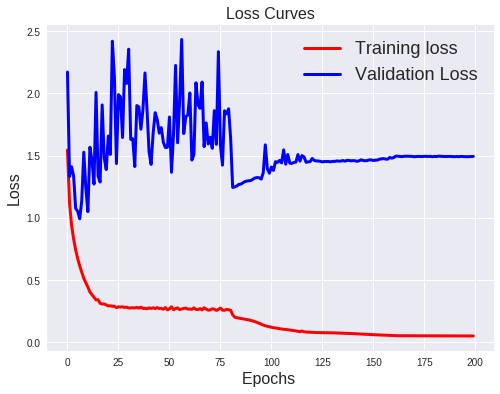

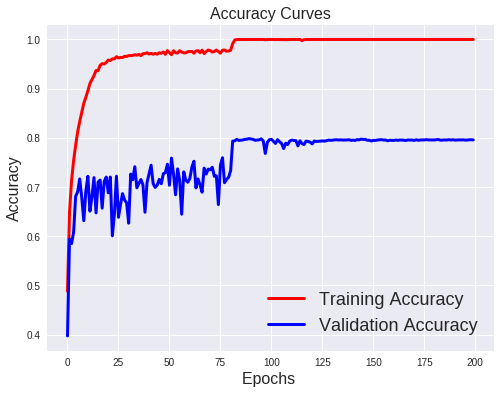

In [20]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
fig1 = plt.gcf()
plt.show()
fig1.savefig('Gray_Avg_loss_curves.png')
files.download('Gray_Avg_loss_curves.png')



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['acc'],'r',linewidth=3.0)
plt.plot(model.history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
fig2 = plt.gcf()
plt.show()
fig2.savefig('Gray_Avg_accuracy_curves.png')
files.download('Gray_Avg_accuracy_curves.png')

In [22]:
predicted_classes = model.predict(grayscale_avg_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
yy_test = np.argmax(np.round(y_test),axis=1)

from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(yy_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.75      0.83      0.79      1000
    Class 1       0.90      0.92      0.91      1000
    Class 2       0.72      0.67      0.69      1000
    Class 3       0.64      0.60      0.62      1000
    Class 4       0.75      0.76      0.76      1000
    Class 5       0.72      0.71      0.71      1000
    Class 6       0.81      0.84      0.83      1000
    Class 7       0.85      0.82      0.83      1000
    Class 8       0.89      0.90      0.89      1000
    Class 9       0.89      0.88      0.89      1000

avg / total       0.79      0.79      0.79     10000



# GrayScale  ITU-R Recommendation BT.601-7

In [0]:
# Create a Grayscale version of the image
def convert_grayscale(kep):
    # Get size
    width, height = 32,32
    # Create new Image and a Pixel Map
    new = kep.copy()
    
    for t in range(len(new)):
        for i in range(width):
            for j in range(height):

                # Get R, G, B values (This are int from 0 to 255)
                red =   new[t,i,j,0]
                green = new[t,i,j,1]
                blue =  new[t,i,j,2]

                # Transform to grayscale
                gray = (red * 0.299) + (green * 0.587) + (blue * 0.114)

                # Set Pixel in new image
                new[t,i, j, 0] = int(gray)
                new[t,i, j, 1] = int(gray)
                new[t,i, j, 2] = int(gray)
                

    # Return new image
    return new

In [0]:
grayscale_train = x_train.copy()
grayscale_train = grayscale_train*255
grayscale_train = convert_grayscale(grayscale_train)
grayscale_test = x_test.copy()
grayscale_test = grayscale_test*255
grayscale_test = convert_grayscale(grayscale_test)

In [0]:
grayscale_train = grayscale_train.astype('float32') / 255
grayscale_test = grayscale_test.astype('float32') / 255

In [13]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(grayscale_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(grayscale_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(grayscale_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_39 (Activation)      (None, 32, 32, 16)   0           batch_normalization_39[0][0]     
_______________________________________________________________________________________

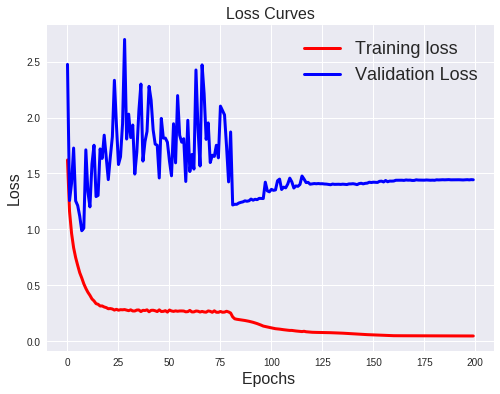

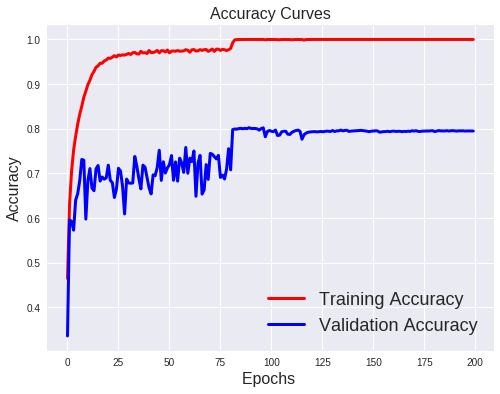

In [14]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
fig1 = plt.gcf()
plt.show()
fig1.savefig('Gray_loss_curves.png')
files.download('Gray_loss_curves.png')



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['acc'],'r',linewidth=3.0)
plt.plot(model.history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
fig2 = plt.gcf()
plt.show()
fig2.savefig('Gray_accuracy_curves.png')
files.download('Gray_accuracy_curves.png')

In [21]:
predicted_classes = model.predict(grayscale_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
yy_test = np.argmax(np.round(y_test),axis=1)

from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(yy_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.74      0.83      0.78      1000
    Class 1       0.90      0.92      0.91      1000
    Class 2       0.72      0.66      0.69      1000
    Class 3       0.64      0.61      0.63      1000
    Class 4       0.75      0.75      0.75      1000
    Class 5       0.71      0.70      0.71      1000
    Class 6       0.81      0.84      0.83      1000
    Class 7       0.85      0.82      0.83      1000
    Class 8       0.89      0.89      0.89      1000
    Class 9       0.88      0.88      0.88      1000

avg / total       0.79      0.79      0.79     10000



# Fekete-fehé**r**

In [0]:
# Create a Grayscale version of the image
def convert_black_and_white(kep,threshold):
    # Get size
    width, height = 32,32
    # Create new Image and a Pixel Map
    new = kep.copy()
    
    for t in range(len(new)):
        for i in range(width):
            for j in range(height):

                # Get R, G, B values (This are int from 0 to 255)
                red =   new[t,i,j,0]
                green = new[t,i,j,1]
                blue =  new[t,i,j,2]

                # Transform to grayscale
                gray = (red * 0.299) + (green * 0.587) + (blue * 0.114)

                if(gray > threshold):
                  
                  # Set Pixel in new image
                  new[t,i, j, 0] = 255
                  new[t,i, j, 1] = 255
                  new[t,i, j, 2] = 255
                  
                else:
                  new[t,i, j, 0] = 0
                  new[t,i, j, 1] = 0
                  new[t,i, j, 2] = 0
                

    # Return new image
    return new

In [0]:
black_and_white_train = x_train.copy()
black_and_white_train = black_and_white_train*255
black_and_white_train = convert_black_and_white(black_and_white_train,200)
black_and_white_test = x_test.copy()
black_and_white_test = black_and_white_test*255
black_and_white_test = convert_black_and_white(black_and_white_test,200)

In [0]:
black_and_white_train = black_and_white_train.astype('float32') / 255
black_and_white_test = black_and_white_test.astype('float32') / 255

In [15]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(black_and_white_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(black_and_white_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(black_and_white_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
_______________________________________________________________________________________

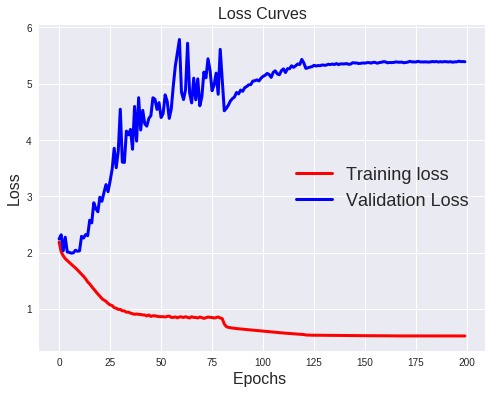

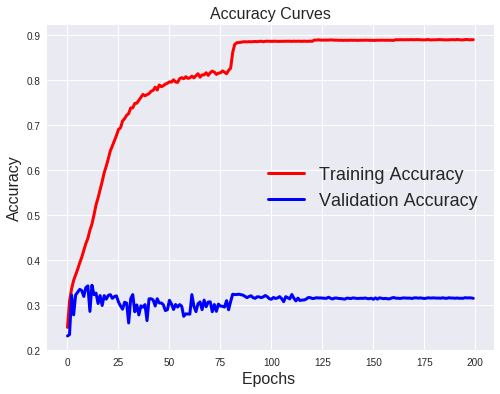

In [16]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
fig1 = plt.gcf()
plt.show()
fig1.savefig('Black_and_white_loss_curves.png')
files.download('Black_and_white_loss_curves.png')



# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(model.history.history['acc'],'r',linewidth=3.0)
plt.plot(model.history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
fig2 = plt.gcf()
plt.show()
fig2.savefig('Black_and_white_accuracy_curves.png')
files.download('Black_and_white_accuracy_curves.png')

In [17]:
predicted_classes = model.predict(black_and_white_test)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
yy_test = np.argmax(np.round(y_test),axis=1)

from sklearn.metrics import classification_report
num_classes = 10
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(yy_test, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.19      0.49      0.27      1000
    Class 1       0.41      0.37      0.39      1000
    Class 2       0.23      0.16      0.19      1000
    Class 3       0.25      0.20      0.22      1000
    Class 4       0.20      0.13      0.16      1000
    Class 5       0.34      0.31      0.33      1000
    Class 6       0.32      0.24      0.27      1000
    Class 7       0.38      0.32      0.35      1000
    Class 8       0.40      0.35      0.37      1000
    Class 9       0.43      0.40      0.42      1000

avg / total       0.31      0.30      0.30     10000

